In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
plt.style.use("fivethirtyeight")

In [2]:
glass = pd.read_csv('glass.csv')

In [3]:
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
glass['Type'].nunique()

6

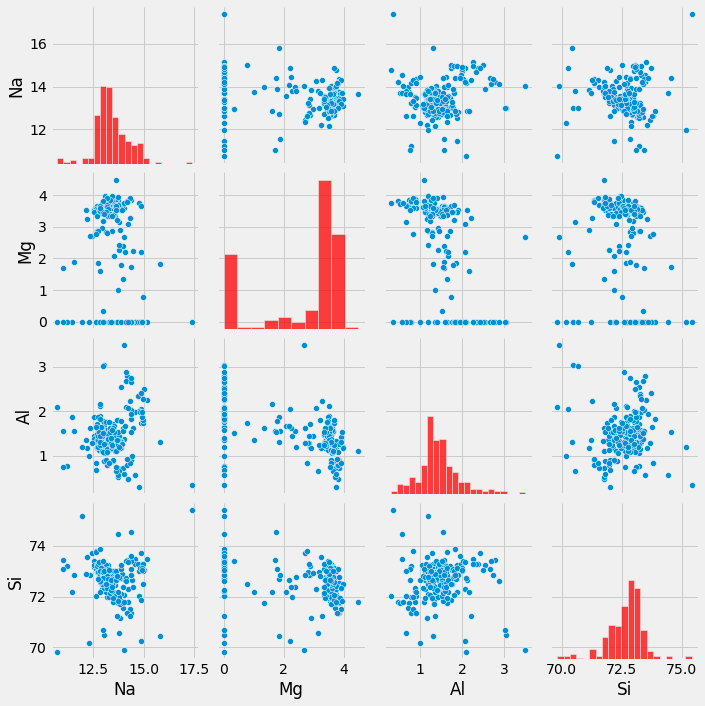

In [5]:
cols_to_plot = ['Na', 'Mg', 'Al', 'Si']
sns.pairplot(glass[cols_to_plot], diag_kws={'color':'red'});

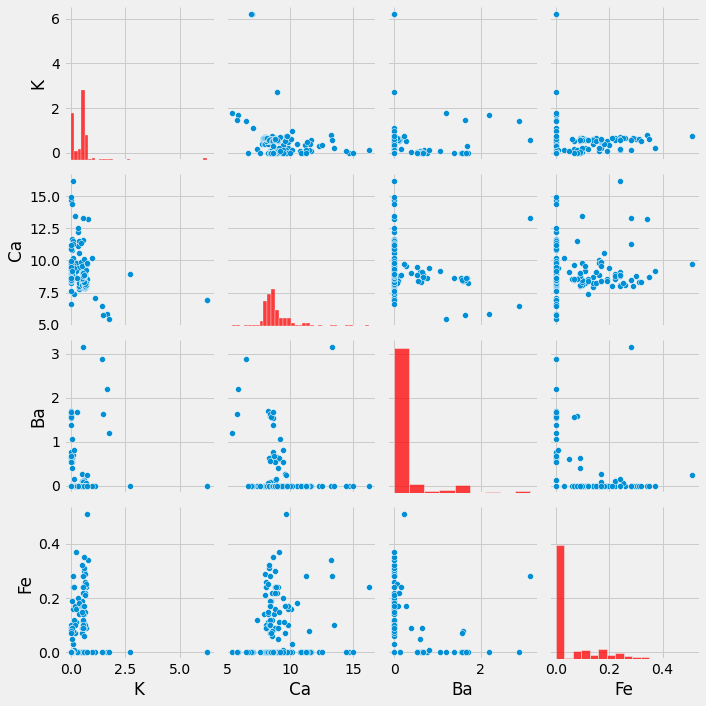

In [6]:
cols_to_plot2 = ['K', 'Ca', 'Ba', 'Fe']
sns.pairplot(glass[cols_to_plot2], diag_kws={'color':'red'});

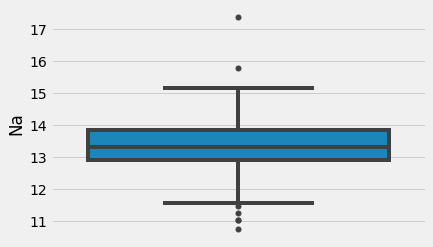

In [7]:
sns.boxplot(data=glass, y="Na", flierprops={"marker": "o"});

In [8]:
# Dimensionality reduction from 10 to 3 dimensions

pca = PCA(n_components=3) 
glass_pca = pca.fit_transform(glass)
print(glass.shape)
print(glass_pca.shape)

(214, 10)
(214, 3)


In [9]:
# PCA visualisation with 3 components, where color represent glass Type

fig = px.scatter_3d(x=glass_pca[:, 0], y=glass_pca[:, 1], z=glass_pca[:, 2],
            color=glass.iloc[:, -1])
fig.show()

## Univariate Outlier Detection

1. Standard Deviation Method

In [10]:
# Find mean, standard deviation and cut off value 
mean = glass["Na"].mean()
std = glass["Na"].std()
cutoff = 3 * std

# Define lower and upper boundaries
lower, upper = mean-cutoff, mean+cutoff

# Define new dataset by masking upper and lower boundaries
new_glass = glass[(glass["Na"] > lower) & (glass["Na"] < upper)]

In [11]:
print(f"Shape of original dataset: {glass.shape}")
print(f"Shape of dataset after removing outliers in Na column: {new_glass.shape}")

Shape of original dataset: (214, 10)
Shape of dataset after removing outliers in Na column: (212, 10)


2. Inter-Quartile Range Method

In [12]:
# Find Q1, Q3, IQR and cut off value 
q25, q75 = np.quantile(glass["Na"], 0.25), np.quantile(glass["Na"], 0.75)
iqr = q75 - q25
cutoff = 1.5 * iqr

# Define lower and upper boundaries
lower, upper = q25 - cutoff, q75 + cutoff

# Define new dataset by masking upper and lower boundaries
new_glass = glass[(glass["Na"] > lower) & (glass["Na"] < upper)]

In [13]:
print(f"Shape of original dataset: {glass.shape}")
print(f"Shape of dataset after removing outliers in Na column: {new_glass.shape}")

Shape of original dataset: (214, 10)
Shape of dataset after removing outliers in Na column: (207, 10)


## Multivariate Outlier Detection

1. Isolation Forest

In [14]:
glass = pd.read_csv('glass.csv')
glass = glass.drop(["Type"], axis=1)

In [15]:
from sklearn.ensemble import IsolationForest

# Initiate isolation forest
isolation = IsolationForest(n_estimators=100, contamination='auto',  max_features=glass.shape[1])

# Fit and predict
isolation.fit(glass)
outliers_predicted = isolation.predict(glass)

# Address outliers in a new column
glass['outlier'] = outliers_predicted

In [16]:
glass['outlier'].value_counts()

 1    195
-1     19
Name: outlier, dtype: int64

In [17]:
pca = PCA(n_components=3) 
glass_pca = pca.fit_transform(glass)

fig = px.scatter_3d(x=glass_pca[:, 0], y=glass_pca[:, 1], z=glass_pca[:, 2],
            color=glass['outlier'], color_continuous_scale=px.colors.sequential.Cividis_r)
fig.show();

2. DBSCAN 

In [18]:
glass = pd.read_csv('glass.csv')
glass = glass.drop(["Type"], axis=1)

In [19]:
from sklearn.preprocessing import MinMaxScaler

glass_x = np.array(glass).astype('float')

scaler = MinMaxScaler()
glass_scaled = scaler.fit_transform(glass_x)

In [20]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.4, min_samples=10).fit(glass_scaled)
glass['outlier'] = dbscan.labels_

In [21]:
glass['outlier'].value_counts()

 0    192
-1     22
Name: outlier, dtype: int64

In [22]:
pca = PCA(n_components=3) 
glass_pca = pca.fit_transform(glass)

fig = px.scatter_3d(x=glass_pca[:, 0], y=glass_pca[:, 1], z=glass_pca[:, 2],
            color=glass['outlier'], color_continuous_scale=px.colors.sequential.Cividis_r)
fig.show();

In [23]:
import math

def calculate_k_distance(X,k):

    k_distance = []
    for i in range(len(X)):
        euclidean_dist = []
        for j in range(len(X)):
            euclidean_dist.append(
                math.sqrt(
                    ((X[i,0] - X[j,0]) ** 2) +
                    ((X[i,1] - X[j,1]) ** 2)))

        euclidean_dist.sort()
        k_distance.append(euclidean_dist[k])

    return k_distance

In [24]:
eps_distance = calculate_k_distance(glass_scaled, 10)
px.histogram(eps_distance, labels={'value':'Epsilon distance'})

3. Local Outlier Factor

In [25]:
glass = pd.read_csv('glass.csv')
glass = glass.drop(["Type"], axis=1)

In [26]:
glass_x = np.array(glass).astype('float')

scaler = MinMaxScaler()
glass_scaled = scaler.fit_transform(glass_x)

In [27]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination='auto')
outliers_predicted = clf.fit_predict(glass_scaled)
glass['outlier'] = outliers_predicted

In [28]:
glass['outlier'].value_counts()

 1    180
-1     34
Name: outlier, dtype: int64

In [29]:
pca = PCA(n_components=3) 
glass_pca = pca.fit_transform(glass)

fig = px.scatter_3d(x=glass_pca[:, 0], y=glass_pca[:, 1], z=glass_pca[:, 2],
            color=glass['outlier'], color_continuous_scale=px.colors.sequential.Cividis_r)
fig.show();